In [ ]:
# %pip install torch torchvision matplotlib opencv-python scikit-image torchxrayvision



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached torch-2.7.0-cp313-cp313-win_amd64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached torchxrayvision-1.3.4-py3-none-any.whl.metadata (18 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached charset_normalizer-3.4.2-cp313-cp313-win_amd64.whl.metadata (36 kB)
  Using cached idna-3

In [3]:

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision
import skimage
import torchxrayvision as xrv


e:\Campus2\fyp-repo\e19-4yp-AI-System-for-Lung-nodule-follow-up-using-plain-chest-X-Ray\.venv\Lib\site-packages\torchxrayvision\utils.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
import os

 -------- 1. Load Model --------

In [5]:
torch.cuda.empty_cache()
model = xrv.models.ResNet(weights="resnet50-res512-all")
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(512)])
model.eval()

XRV-ResNet-resnet50-res512-all

-------- 2. Load and Transform Image --------

In [6]:
img_path = "testxray.png"  # 🔁 Change this to your own image

# Infer mask path
mask_path = img_path.replace(".png", "_mask.png")
if not os.path.exists(mask_path):
    raise FileNotFoundError(f"Expected mask file: {mask_path}")

# Load and process mask
raw_mask = skimage.io.imread(mask_path)
if raw_mask.ndim == 3:  # Convert RGB to grayscale if needed
    raw_mask = cv2.cvtColor(raw_mask, cv2.COLOR_RGB2GRAY)

# Resize to 512x512 to match transformed image
mask_resized = cv2.resize(raw_mask, (512, 512), interpolation=cv2.INTER_NEAREST)

# Convert to boolean mask
binary_mask = (mask_resized > 127).astype(np.bool_)

img = skimage.io.imread(img_path)
img = xrv.datasets.normalize(img, 512) # convert 8-bit image to [-1024, 1024] range
img = img[None, ...] # Add channel dimension for grayscale image
img = transform(img)
img = torch.from_numpy(img)

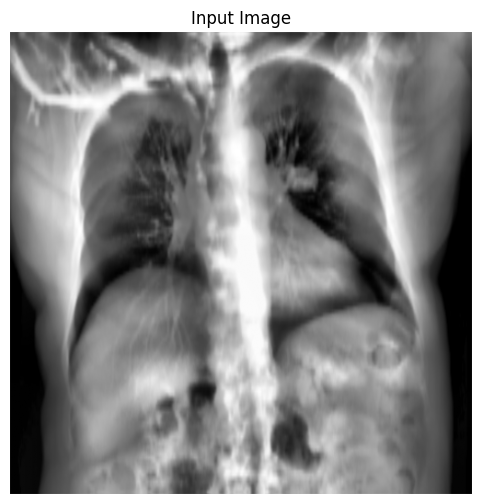

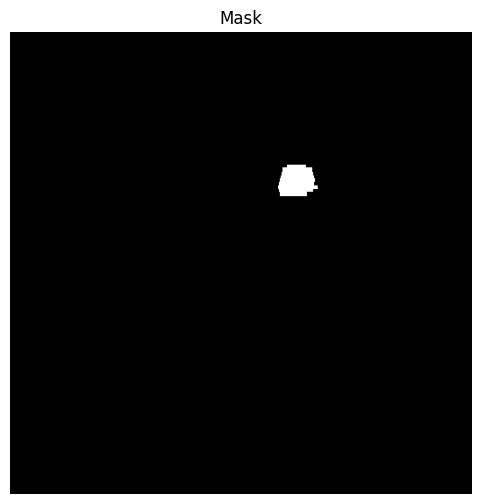

In [7]:
plt.figure(figsize=(6, 6))
plt.imshow(img[0], cmap="gray")
plt.title("Input Image")
plt.axis("off")
plt.show()

# show mask
plt.figure(figsize=(6, 6))
plt.imshow(binary_mask, cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()

-------- 3. Register Hooks on ResNet50 --------

In [8]:
feature_maps = []
gradients = []

def forward_hook(module, input, output):
    feature_maps.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

In [9]:
# Final conv layer in ResNet50 (before avgpool)
target_layer = model.model.layer4[-1].conv3
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

 -------- 4. Forward and Backward Pass --------

In [10]:
output = model(img[None,...])

In [16]:
# Select class index for 'Lung Nodule' (you might need to confirm the correct index)
class_idx = model.pathologies.index("Nodule")  # usually around 8
nodule_score = output[0, class_idx]
print(f"Nodule score: {nodule_score.item():.3f}")

# show all for each class
for i in range(len(model.pathologies)):
    _ = output[0, i]
    print(f"{model.pathologies[i]} score: {_.item():.3f}")


Nodule score: 0.134
Atelectasis score: 0.123
Consolidation score: 0.086
Infiltration score: 0.127
Pneumothorax score: 0.053
Edema score: 0.013
Emphysema score: 0.055
Fibrosis score: 0.015
Effusion score: 0.100
Pneumonia score: 0.002
Pleural_Thickening score: 0.039
Cardiomegaly score: 0.005
Nodule score: 0.134
Mass score: 0.940
Hernia score: 0.000
Lung Lesion score: 0.500
Fracture score: 0.038
Lung Opacity score: 0.000
Enlarged Cardiomediastinum score: 0.500


In [12]:
model.zero_grad()
nodule_score.backward()

 -------- 5. Generate Grad-CAM --------

In [13]:
grads_val = gradients[0]             # Shape: [1, C, H, W]
feature_maps_val = feature_maps[0]  # Shape: [1, C, H, W]

weights = grads_val.mean(dim=(2, 3), keepdim=True)  # Global avg pooling over H and W
cam = (weights * feature_maps_val).sum(dim=1).squeeze().detach().cpu().numpy()
cam = np.maximum(cam, 0)
cam = cam / cam.max()  # Normalize to [0,1]


 -------- 6. Overlay CAM on Image --------

In [14]:
cam_resized = cv2.resize(cam, (img[0].shape[1], img[0].shape[0]), interpolation=cv2.INTER_LINEAR)
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

img_rgb = np.uint8(255 * np.stack([cam_resized]*3, axis=-1))  # shape: (512, 512, 3)

# Resize heatmap to match
cam_resized = cv2.resize(cam, (512, 512))     # shape: (512, 512)
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)  # shape: (512, 512, 3)

# Combine
overlay = cv2.addWeighted(img_rgb, 0.5, heatmap, 0.5, 0)


 -------- 7. Display --------

In [15]:
# Create dummy label tensor (no need for correct labels for localization eval)
labels = torch.tensor([[0]*len(model.pathologies)])

# Pathology mask dictionary (as list for batch)
pathology_mask = [{"Nodule": binary_mask}]

# Threshold CAM to create binary prediction mask
cam_threshold = 0.3  # You can adjust this threshold
cam_pred = cam_resized > cam_threshold

# Compute Intersection over Union (IoU)
intersection = np.logical_and(cam_pred, binary_mask).sum()
union = np.logical_or(cam_pred, binary_mask).sum()
iou = intersection / union if union > 0 else 0.0

# Compute Dice coefficient
dice = (2 * intersection) / (cam_pred.sum() + binary_mask.sum()) if (cam_pred.sum() + binary_mask.sum()) > 0 else 0.0

print(f"IoU: {iou:.3f}")
print(f"Dice coefficient: {dice:.3f}")

IoU: 0.101
Dice coefficient: 0.184


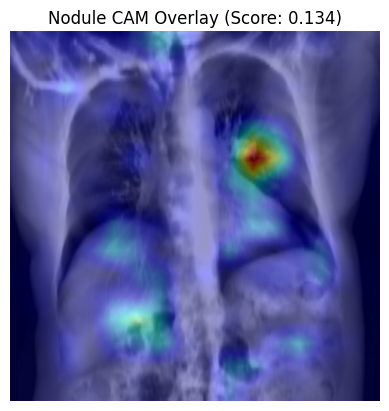

In [30]:
plt.imshow(img[0], cmap="gray")
plt.imshow(cam_resized, cmap="jet", alpha=0.4)  # smooth + transparent
plt.title(f"Nodule CAM Overlay (Score: {nodule_score.item():.3f})")
plt.axis("off")
plt.show()